### H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001)

We illustrate the program with the driven and damped qubit example studied in - H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qt_unraveling as qtr

import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%load_ext autotime
%load_ext line_profiler

In [2]:
## Parameters 
gamma = 1
omega = 10

## Time parameters
t0 = 0.
tf = 10
time_steps = 10000
dt = int(abs(tf-t0)/time_steps)

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
psi0 = np.array([1,1], dtype = np.complex128)
rho0 = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C')

## Hamiltonian
def H0(t):
    return omega/2.0 * np.array([[0,1],[1,0]], dtype=np.complex128, order='C') 

## Lindblad operators
def L():
    return [np.sqrt(gamma)*qtr.sigmam]

## feedback test
def F():
    return [qtr.sigmay, qtr.sigmaz]

## Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
# You have the option to define an adaptive unraveling. This is done by defining it in term of a function of t and the state

## Fixed unraveling
u_matrix = 0*np.eye(len(L()))

## Adapative unraveling
#def u_matrix(t, rho):
#    return np.array([[-np.trace(np.dot(rho,qtr.sigmam))/np.trace(np.dot(rho,qtr.sigmap))]])

time: 4.52 ms


### Basic functionalities

This library is based on two main unraveling schemes: quantum jump (QJump) and diffusive schemes. The following shows how you can use the basic functionalities of this library. You can start by using the System class, which gives support to every unraveling method on the library:

In [3]:
## System class init
test = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_matrix, FList = F)

time: 70.5 ms


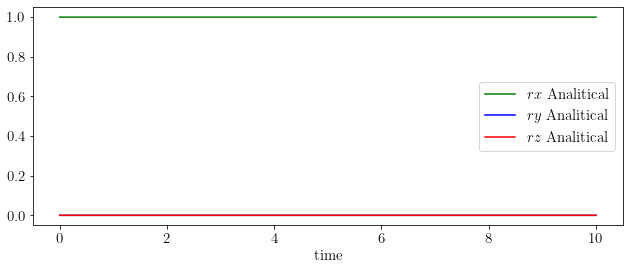

time: 836 ms


In [4]:
## Von Neumann evolution
anali = test.VonNeumannAnalitical()

# Von Neumann plot
rx, ry, rz = qtr.rhoBlochrep_data(anali)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=4)

axs.plot(t, rx, '-', label = r'$rx$ Analitical', color = "g")
axs.plot(t, ry, '-', label = r'$ry$ Analitical', color = "b")
axs.plot(t, rz, '-', label = r'$rz$ Analitical', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()

In [24]:
## Average conditional Qjump evoltuion
rho_qjump = test.jumpRhoAverage(1000, traj_type = 'vector', time_dep = False)

time: 6min 4s


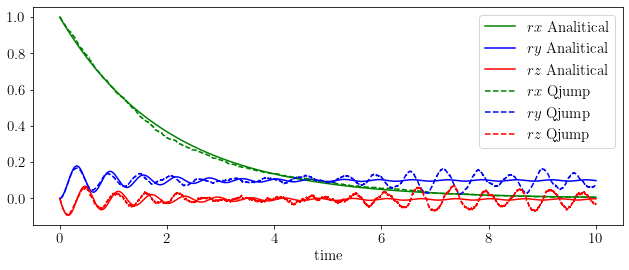

time: 1.1 s


In [25]:
# Anlitical unconditional Qjump evolution
rhoUana = test.lindbladAnalitical()

## Qjumps plot
rx_1, ry_1, rz_1 = qtr.rhoBlochrep_data(rhoUana)
rx_2, ry_2, rz_2 = qtr.rhoBlochrep_data(rho_qjump)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=4)

axs.plot(t, rx_1, '-', label = r'$rx$ Analitical', color = "g")
axs.plot(t, ry_1, '-', label = r'$ry$ Analitical', color = "b")
axs.plot(t, rz_1, '-', label = r'$rz$ Analitical', color = "r")

axs.plot(t, rx_2, '--', label = r'$rx$ Qjump', color = "g")
axs.plot(t, ry_2, '--', label = r'$ry$ Qjump', color = "b")
axs.plot(t, rz_2, '--', label = r'$rz$ Qjump', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()

In [9]:
## Average conditional diffusive evoltuion
rho_diff = test.diffusiveRhoAverage(750, method = 'euler', parallelfor = True)

time: 8min 5s


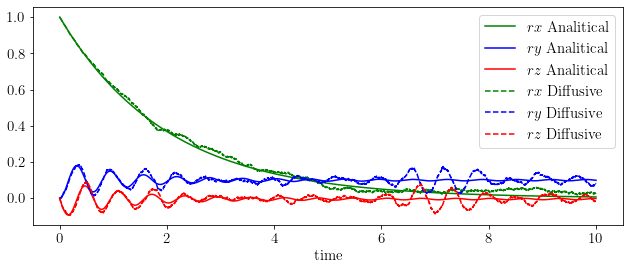

time: 1.72 s


In [10]:
# Anlitical unconditional diffusive evolution
rhoUana = test.lindbladAnalitical()

## Diffusive plot
rx_1, ry_1, rz_1 = qtr.rhoBlochrep_data(rhoUana)
rx_2, ry_2, rz_2 = qtr.rhoBlochrep_data(rho_diff)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=4)

axs.plot(t, rx_1, '-', label = r'$rx$ Analitical', color = "g")
axs.plot(t, ry_1, '-', label = r'$ry$ Analitical', color = "b")
axs.plot(t, rz_1, '-', label = r'$rz$ Analitical', color = "r")

axs.plot(t, rx_2, '--', label = r'$rx$ Diffusive', color = "g")
axs.plot(t, ry_2, '--', label = r'$ry$ Diffusive', color = "b")
axs.plot(t, rz_2, '--', label = r'$rz$ Diffusive', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()

In [15]:
## Average conditional feedback evoltuion
average_feed = test.feedRhoAverage(n_trajectories = 100, method = 'euler', parallelfor = True)

time: 1min 30s


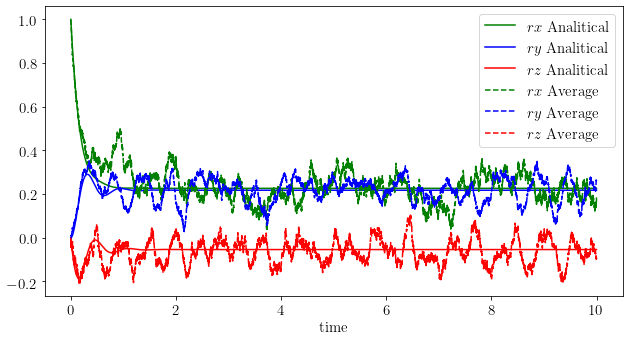

time: 1.88 s


In [21]:
# Anlitical unconditional feedback evolution
anali_feed = test.feedAnaliticalUncond(3, 1e-12, 1e-12)

# Feedback plot
rx_1, ry_1, rz_1 = qtr.rhoBlochrep_data(anali_feed)
rx_2, ry_2, rz_2 = qtr.rhoBlochrep_data(average_feed)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=5)

axs.plot(t, rx_1, '-', label = r'$rx$ Analitical', color = "g")
axs.plot(t, ry_1, '-', label = r'$ry$ Analitical', color = "b")
axs.plot(t, rz_1, '-', label = r'$rz$ Analitical', color = "r")

axs.plot(t, rx_2, '--', label = r'$rx$ Average', color = "g")
axs.plot(t, ry_2, '--', label = r'$ry$ Average', color = "b")
axs.plot(t, rz_2, '--', label = r'$rz$ Average', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()

### Quantum jump connection to the diffusive unraveling

The Qjump methods are equiped with an unraveling option that allows us to explore the continous limit of the this scheme

In [12]:
## Large coherent field mu and small time step dt
mu = 10
steps = 50000
t = np.linspace(t0, tf, steps)

## u set the unraveling, u = 1 homodyne x quadrature, u = -1 homodyne y quadrature, u = 0 heterodyne of x and y qudratures
u_matrix = np.eye(len(L()))
h_matrix = np.eye(len(L()))

## System class init
discrete_test = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_matrix, HMatrix = h_matrix, FList = F, amp = [mu, mu])

time: 9.76 ms


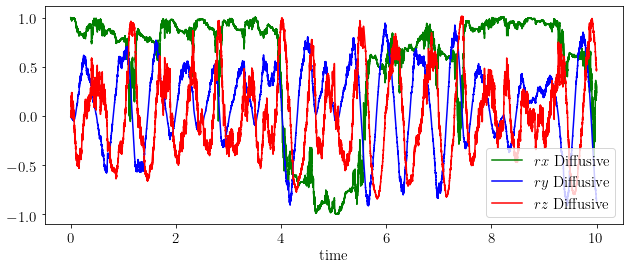

time: 12.1 s


In [13]:
## Diffusive trajectory
rho_diff = discrete_test.diffusiveRhoTrajectory(1, method = 1)

## Diffusive plot
rx, ry, rz = qtr.rhoBlochrep_data(rho_diff)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=4)

axs.plot(t, rx, '-', label = r'$rx$ Diffusive', color = "g")
axs.plot(t, ry, '-', label = r'$ry$ Diffusive', color = "b")
axs.plot(t, rz, '-', label = r'$rz$ Diffusive', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()

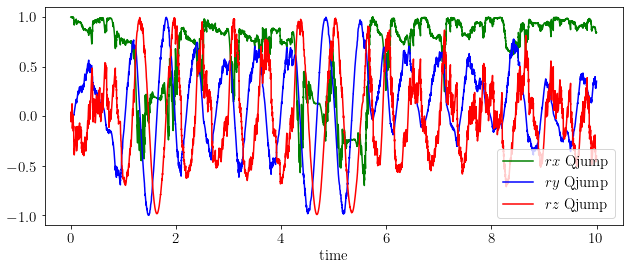

time: 42.5 s


In [14]:
## Qjump trajectory
rho_qjump = discrete_test.jumpRhoTrajectory(1, unraveling = True)

## Qjumps plot
rx, ry, rz = qtr.rhoBlochrep_data(rho_qjump)

## Plot settings
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots()
fig.set_size_inches(w=9, h=4)

axs.plot(t, rx, '-', label = r'$rx$ Qjump', color = "g")
axs.plot(t, ry, '-', label = r'$ry$ Qjump', color = "b")
axs.plot(t, rz, '-', label = r'$rz$ Qjump', color = "r")

plt.xlabel('time')
plt.tight_layout()
plt.legend()